# Evaluation of Figure 1

In this notebook, the data for Figure 1 is prepared. Note, that due to known issues in the umap-learn package, the plots are not 100% reproducable over all machines. However the overall structure will be preserved.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import anndata
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../mvTCR/')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

C:\Users\felix.drost\Anaconda3\envs\mvTCR_repro2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Celltype

In [3]:
import celltypist
from celltypist import models

In [4]:
data_full = sc.read('../mvTCR/data/10x_CD8TC/logged_10x.h5ad')
data_full.uns['log1p']['base'] = None

In [5]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 19
📂 Storing models in C:\Users\felix.drost\.celltypist\data\models
💾 Downloading model [1/19]: Immune_All_Low.pkl
💾 Downloading model [2/19]: Immune_All_High.pkl
💾 Downloading model [3/19]: Adult_Mouse_Gut.pkl
💾 Downloading model [4/19]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [5/19]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [6/19]: COVID19_Immune_Landscape.pkl
💾 Downloading model [7/19]: Cells_Fetal_Lung.pkl
💾 Downloading model [8/19]: Cells_Intestinal_Tract.pkl
💾 Downloading model [9/19]: Cells_Lung_Airway.pkl
💾 Downloading model [10/19]: Developing_Human_Brain.pkl
💾 Downloading model [11/19]: Developing_Human_Thymus.pkl
💾 Downloading model [12/19]: Developing_Mouse_Brain.pkl
💾 Downloading model [13/19]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [14/19]: Human_IPF_Lung.pkl
💾 Downloading model [15/19]: Human_Lung_Atlas.pkl
💾 Downloading model [16/19]:

In [6]:
# Immune_All_High.pkl
predictions = celltypist.annotate(data_full, model='Immune_All_Low.pkl', majority_voting=True)
cd8_types = [
    'Tem/Trm cytotoxic T cells',
    'Tem/Temra cytotoxic T cells',
    'Tcm/Naive cytotoxic T cells',
    'NKT cells',
    'MAIT cells',
    'Trm cytotoxic T cells',
]
predictions.predicted_labels['predicted_labels'] = predictions.predicted_labels['predicted_labels'
                                                                               ].apply(lambda x: x 
                                                                                       if x in cd8_types 
                                                                                       else 'Unknown') 
predictions.predicted_labels['predicted_labels'].value_counts()

🔬 Input data has 178356 cells and 19707 genes
🔗 Matching reference genes in the model
🧬 5164 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


Tem/Trm cytotoxic T cells      65905
Tcm/Naive cytotoxic T cells    45612
Tem/Temra cytotoxic T cells    44157
Unknown                        16425
MAIT cells                      5184
Trm cytotoxic T cells            852
NKT cells                        221
Name: predicted_labels, dtype: int64

## Load model

In [7]:
def load_model(adata, model, donor='None'):
    #path_model = f'saved_models/journal/10x/full/donor_{donor}/{model}_'
    path_model = f'saved_models/journal_2/10x/full/10x_{donor}_full_{model}.pt'
    #path_model += f'donor_{donor}_full.pt'
    model = utils.load_model(adata, path_model)
    adata.obs['set'] = 'train'
    return model
    

In [8]:
binder_2_donor = {
    'donor_1': const.donor_1_high_count_antigens,
    'donor_2': const.donor_2_high_count_antigens,
    'donor_3': const.donor_3_high_count_antigens,
    'donor_4': const.donor_4_high_count_antigens,
    'full': const.HIGH_COUNT_ANTIGENS,
    'None': const.HIGH_COUNT_ANTIGENS,
}

In [9]:
from sklearn.preprocessing import OneHotEncoder
def load_10x_data(donor='None'):
    adata = utils.load_data('10x')
    adata = adata[adata.obs['binding_name'].isin(const.HIGH_COUNT_ANTIGENS)]
    if donor != 'None':
        adata = adata[adata.obs['donor']==donor]
    enc = OneHotEncoder(sparse=False)
    enc.fit(adata.obs['donor'].to_numpy().reshape(-1, 1))
    adata.obsm['donor'] = enc.transform(adata.obs['donor'].to_numpy().reshape(-1, 1))
    return adata

## Loading

In [10]:
def add_clonotypes(latent):
    expanded_clonotypes = latent.obs['clonotype'].value_counts()
    expanded_clonotypes = expanded_clonotypes[:9].index
    
    latent.obs['large_clonotype'] = [el if el in expanded_clonotypes
                                  else 'Other' 
                                  for el in latent.obs['clonotype']]
    latent.obs['large_clonotype'] = latent.obs['large_clonotype'].astype(str)

In [11]:
for donor in tqdm(['donor_1', 'donor_2', 'donor_3', 'donor_4', 'None']):
    data = load_10x_data(donor)
    data.obs['celltype'] = predictions.predicted_labels['predicted_labels']
    for model_name in ['moe', 'rna', 'tcr', 'concat', 'poe']:
        model = load_model(data, model_name, donor)
        latent = model.get_latent(data, metadata=['donor', 'binding_name', 'clonotype'], return_mean=True)
        sc.pp.neighbors(latent, use_rep='X')
        sc.tl.umap(latent)
        
        add_clonotypes(latent)
        latent.obs['celltype'] = predictions.predicted_labels['predicted_labels']
        
        if (donor == 'None') and (model_name == 'moe'):
            model.get_modality_contribution(data)
            latent.obs['Contribution TCR'] = data.obs['contribution_tcr-rna']
        
        sc.write(adata=latent, filename=f'../results/fig1_{model_name}_{donor}_full.h5ad')     

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
 20%|████████████████▌                                                                  | 1/5 [02:11<08:44, 131.13s/it]... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'la

## Leiden annotation based on best NMI value

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:29<00:00,  7.45s/it]


moe - NMI: 0.5351123823882216


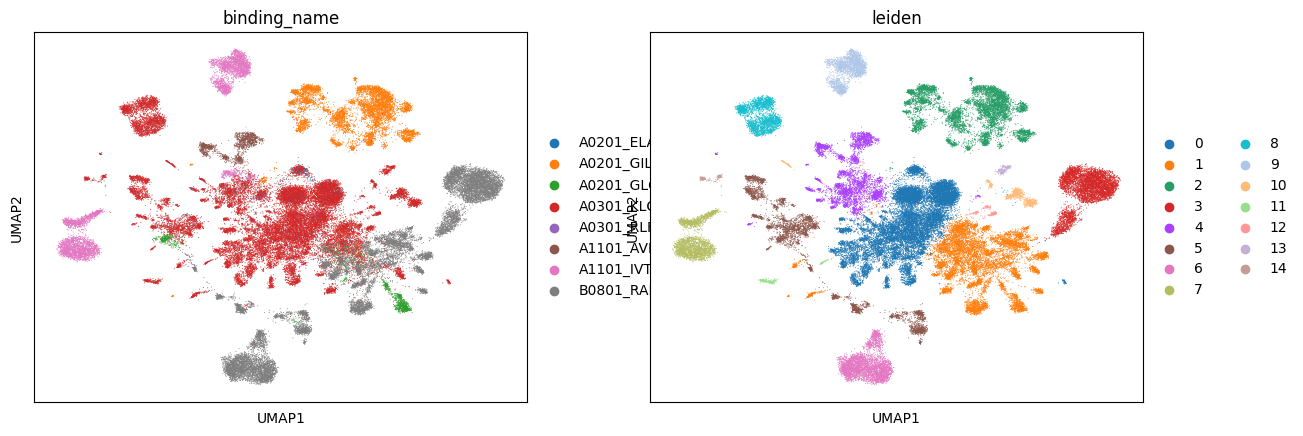

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:59<00:00,  9.95s/it]


rna - NMI: 0.45578279489556733


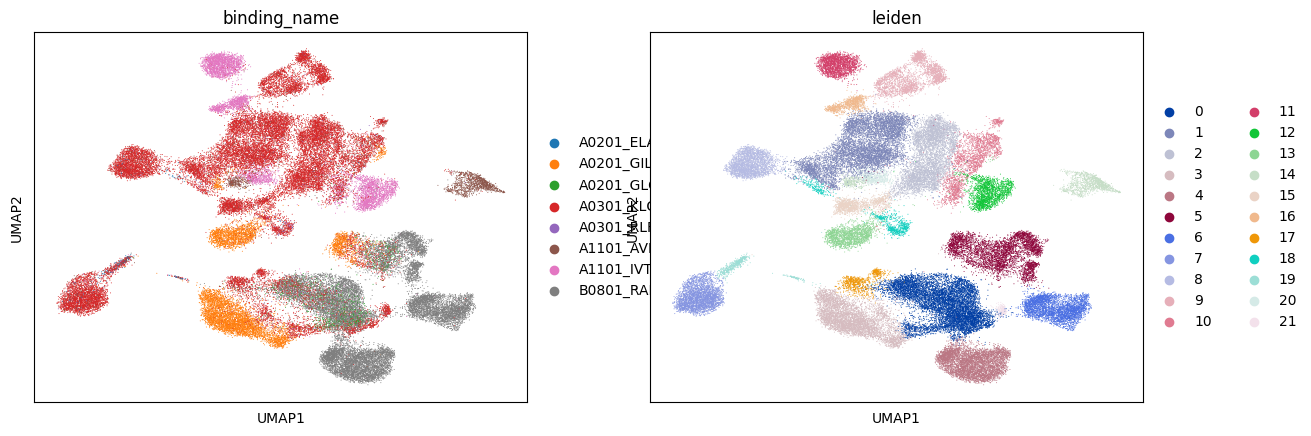

In [12]:
from sklearn.metrics import normalized_mutual_info_score

def annotate_best_leiden(model):
    latent = sc.read(f'../results/fig1_{model}_None_full.h5ad')
    sc.pp.neighbors(latent)
    best_nmi = -99
    best_res = -99
    for resolution in tqdm([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        sc.tl.leiden(latent, resolution=resolution)
        cluster_result = normalized_mutual_info_score(latent.obs['binding_name'], 
                                                      latent.obs['leiden'], average_method='arithmetic')
        if best_nmi < cluster_result:
            best_nmi = cluster_result
            best_res = resolution

    print(f'{model} - NMI: {best_nmi}')
    sc.tl.leiden(latent, resolution=best_res)
    sc.pl.umap(latent, color=['binding_name', 'leiden'])
    sc.write(adata=latent, filename=f'../results/fig1_{model}_None_full.h5ad')
    return latent

latent_moe = annotate_best_leiden('moe')
latent_rna = annotate_best_leiden('rna')

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:18<00:00,  6.57s/it]


tcr - NMI: 0.40779197984136895


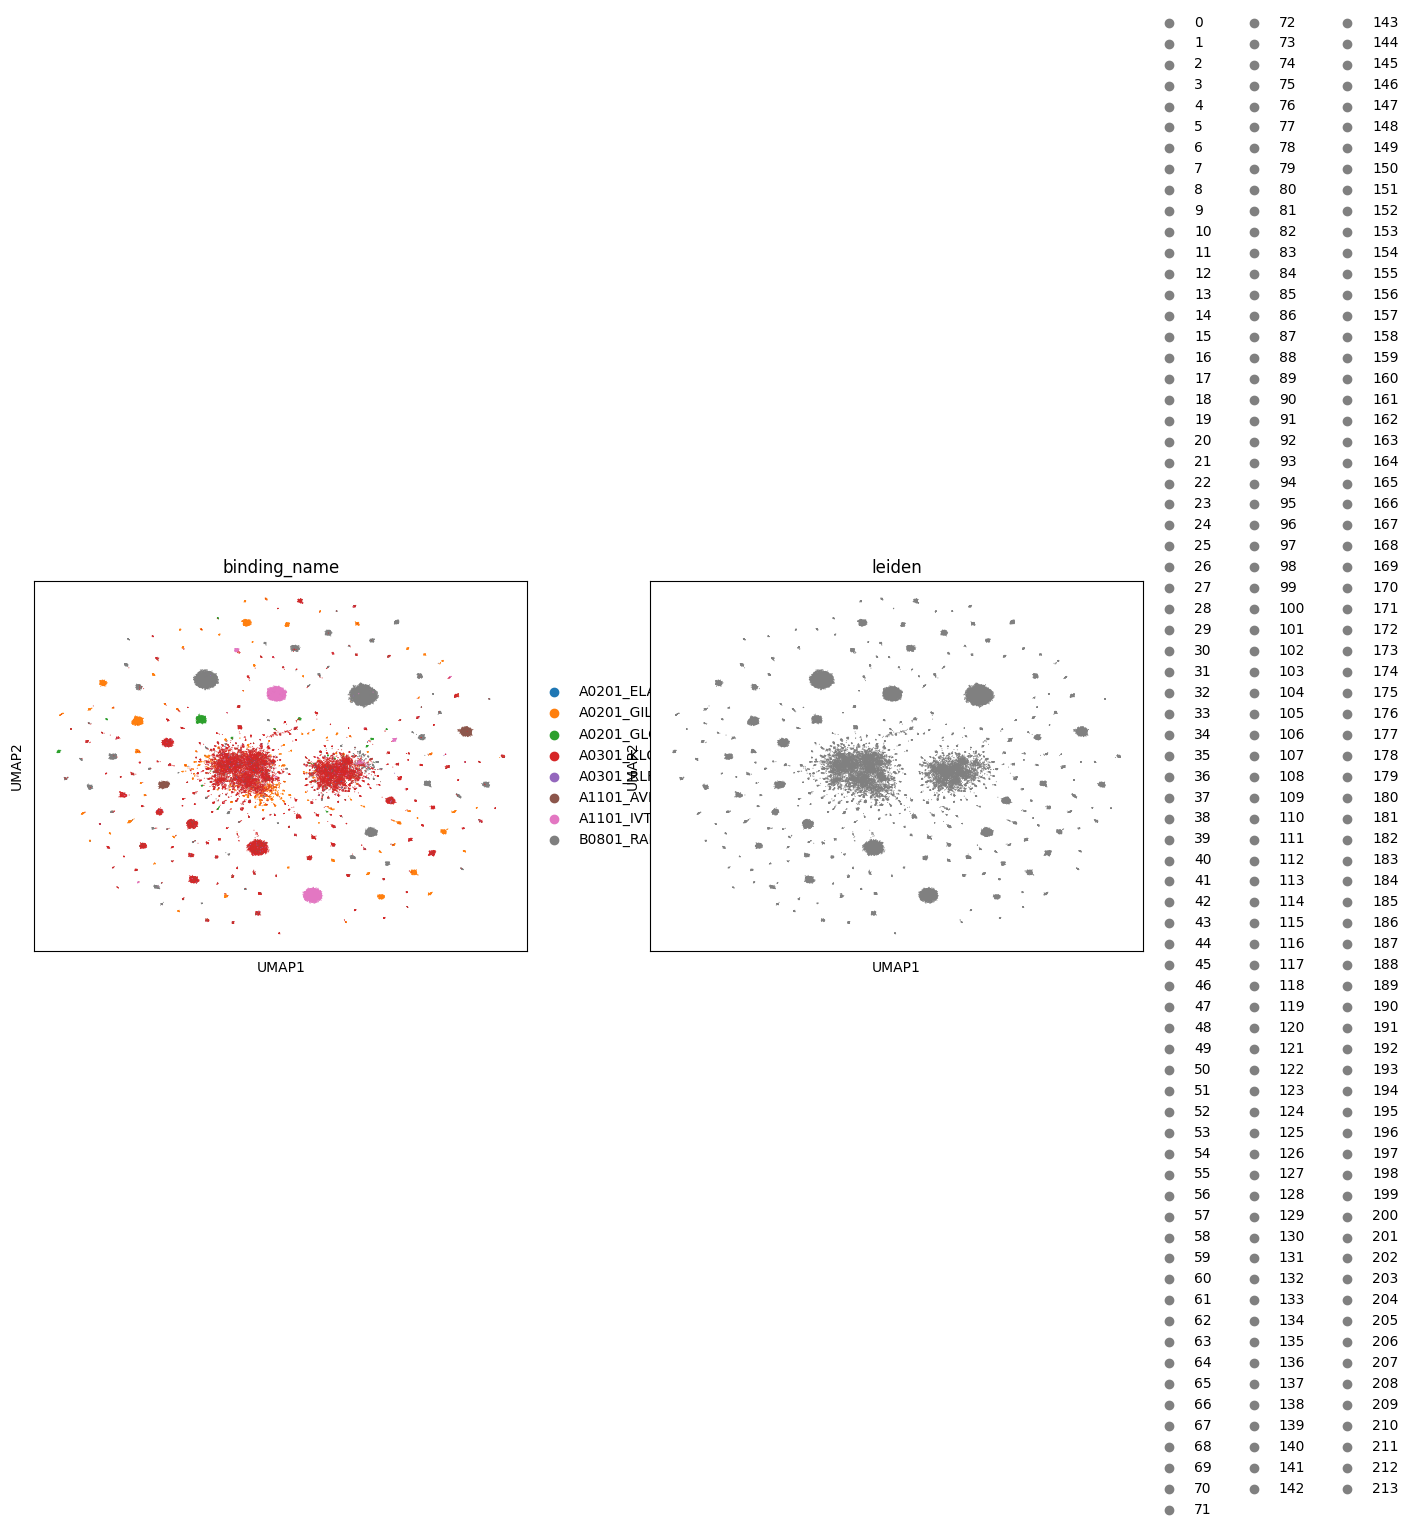

In [13]:
latent_rna = annotate_best_leiden('tcr')

## TcrDist

In [14]:
data = load_10x_data('None')
latent_moe = sc.read(f'../results/fig1_moe_None_full.h5ad')

In [15]:
from tcrdist.repertoire import TCRrep
from tcrdist.tree import TCRtree
from tqdm import tqdm

In [16]:
latent_moe.uns['pw_tcrdist'] = {}
for epitope in tqdm(data.obs['binding_name'].unique()):
    adata_tmp = data[data.obs['binding_name']==epitope]

    df_clonotype = adata_tmp.obs[['IR_VJ_1_v_call', 'IR_VJ_1_junction_aa', 
                         'IR_VDJ_1_v_call', 'IR_VDJ_1_junction_aa', 'clonotype']]
    df_clonotype = df_clonotype.drop_duplicates(['IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa'])
    df_clonotype = df_clonotype.reset_index(drop=True)
    df_clonotype = df_clonotype.rename(columns={
        'IR_VJ_1_v_call': 'v_a_gene',
        'IR_VJ_1_junction_aa': 'cdr3_a_aa',

        'IR_VDJ_1_v_call': 'v_b_gene',
        'IR_VDJ_1_junction_aa':  'cdr3_b_aa'
    })

    for col in df_clonotype.columns:
        dtype = str
        df_clonotype[col] = df_clonotype[col].astype(dtype)

    df_clonotype['v_a_gene'] = df_clonotype['v_a_gene'] + '*01'
    df_clonotype['v_b_gene'] = df_clonotype['v_b_gene'] + '*01'

    tr = TCRrep(cell_df=df_clonotype, organism='human', chains=['alpha','beta'])
    dists = tr.pw_alpha + tr.pw_beta

    dists = np.triu(dists, k=1) # mask lower triangular + diagonal entries
    dists[dists==0] = -99

    columns = tr.clone_df['clonotype']
    #dists = pd.DataFrame(dists, columns=columns, index=columns)
    dists = dists[dists!=-99]
    latent_moe.uns['pw_tcrdist'][epitope] = dists.copy()
    
sc.write(adata=latent_moe, filename=f'../results/fig1_moe_None_full.h5ad')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:43<00:00,  5.39s/it]
